# Run a simulation

In [12]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
import h5py
from tqdm import trange

### Calculate particle forces using bondlist

In [13]:
@njit(parallel=True)
def calculate_nodal_forces(bondlist, x, u, d, c, cell_volume,
                           sc, f_x, f_y, node_force):
    """
    Calculate particle forces - employs bondlist

    Parameters
    ----------
    bondlist : ndarray (int)
        Array of pairwise interactions (bond list)
    x : ndarray (float)
        Material point coordinates in the reference configuration
    u : ndarray (float)
        Nodal displacement
    d : ndarray (float)
        Bond damage (softening parameter). The value of d will range from 0
        to 1, where 0 indicates that the bond is still in the elastic range,
        and 1 represents a bond that has failed
    c : float
        Bond stiffness

    Returns
    -------
    node_force : ndarray (float)
        Nodal force array
    d : ndarray (float)
        Bond damage (softening parameter). The value of d will range from 0
        to 1, where 0 indicates that the bond is still in the elastic range,
        and 1 represents a bond that has failed

    Notes
    -----
    * Can the constitutive model function be passed in as an argument?
    
    """

    n_bonds = np.shape(bondlist)[0]
    
    for k_bond in prange(n_bonds):

        node_i = bondlist[k_bond, 0] - 1
        node_j = bondlist[k_bond, 1] - 1

        xi_x = x[node_j, 0] - x[node_i, 0]
        xi_y = x[node_j, 1] - x[node_i, 1]

        xi_eta_x = xi_x + (u[node_j, 0] - u[node_i, 0])
        xi_eta_y = xi_y + (u[node_j, 1] - u[node_i, 1])

        xi = np.sqrt(xi_x**2 + xi_y**2)
        y = np.sqrt(xi_eta_x**2 + xi_eta_y**2)
        stretch = (y - xi) / xi

        # TODO: allow the user to load different constitutive models or define
        # a new law that describes the interaction between two particles
        d[k_bond] = linear_constitutive_model(stretch, sc, d[k_bond])

        f = stretch * c * (1 - d[k_bond]) * cell_volume
        f_x[k_bond] = f * xi_eta_x / y
        f_y[k_bond] = f * xi_eta_y / y

    # Reduce bond forces to particle forces
    for k_bond in range(n_bonds):

        node_i = bondlist[k_bond, 0] - 1
        node_j = bondlist[k_bond, 1] - 1

        node_force[node_i, 0] += f_x[k_bond]
        node_force[node_j, 0] -= f_x[k_bond]
        node_force[node_i, 1] += f_y[k_bond]
        node_force[node_j, 1] -= f_y[k_bond]

    return node_force, d

### Update particle positions

In [14]:
@njit(parallel=True)
def update_nodal_positions(node_force, u, v, a, damping,
                           node_density, dt, 
                           bc_flag, bc_magnitude, bc_unit_vector):
    """
    Update particle positions using an Euler-Cromer time integration scheme
    
    Parameters
    ----------
    u : ndarray (float)
        Particle displacement
    v : ndarray (float)
        Particle velocity
    a : ndarray (float)
        Particle acceleration

    Returns
    -------

    Notes
    -----

    """

    n_nodes = np.shape(node_force)[0]
    n_dimensions = np.shape(node_force)[1]

    for node_i in prange(n_nodes):
        for dof in range(n_dimensions):
            a[node_i, dof] = (node_force[node_i, dof] - damping * v[node_i, dof]) / node_density
            v[node_i, dof] = v[node_i, dof] + (a[node_i, dof] * dt)
            u[node_i, dof] = u[node_i, dof] + (v[node_i, dof] * dt)
            
            # TODO: how should boundary conditions be applied?
            if bc_flag[node_i, dof] != 0:
                u[node_i, dof] = bc_magnitude * bc_unit_vector[node_i, dof]

    return u, v

### Constitutive model

In [15]:
@njit
def linear_constitutive_model(stretch, sc, d):
    """
    Linear constitutive model
    """
    
    d_temp = 0.0
    
    if stretch < sc:
        d_temp = 0.0
        
    elif stretch >= sc:
        d_temp = 1.0
        
    # Bond softening factor can only increase (damage is irreversible)
    if d_temp > d:
        d = d_temp
    
    return d

In [16]:
@njit
def trilinear_constitutive_model(stretch, s0, s1, sc, d, beta):
    """
    Trilinear constitutive model
    """

    eta = s1 / s0
    d_temp = 0.0

    if (stretch > s0) and (stretch <= s1):
        d_temp = 1 - ((eta - beta) / (eta - 1) * (s0 / stretch)) + ((1 - beta) / (eta - 1))
        
    elif (stretch > s1) and (stretch <= sc):
        d_temp = 1 - (s0 * beta / stretch) * ((sc - stretch) / (sc - s1))
    
    elif stretch > sc:
        d_temp = 1.0

    # Bond softening factor can only increase (damage is irreversible)
    if d_temp > d:
        d = d_temp

    return d


### Smooth step data (apply boundary conditions)

In [17]:
@njit
def smooth_step_data(current_time_step, start_time_step, final_time_step,
                     start_value, final_value):
    """
    Smooth 5th order polynomial
    """
    xi = (current_time_step - start_time_step) / (final_time_step - start_time_step)
    alpha = start_value + (final_value - start_value) * xi**3 * (10 - 15 * xi + 6 * xi**2)

    return alpha

### Read input file (HDF5 format)

In [18]:
def read_input_file(filename):
    """
    Read input file 
    
    Parameters
    ----------
    filename : str

    Returns
    -------
    input_file : dict
    
    Notes
    -----
    * Is it possible to deconstuct a dictionary?
    
    """
    
    input_file = {}
    
    with h5py.File(filename, "r") as h5file:
        for key, values in h5file.items():
            input_file[key] = np.array(values)

    return input_file

In [19]:
def read_array():
    pass

### Run simulation

In [20]:
def run_simulation(filename, dt, n_time_steps, damping, applied_displacement):
    
    input_file = read_input_file(filename)
    
    n_nodes = len(input_file['x'])
    n_bonds = len(input_file['bondlist'])
    
    u = np.zeros([n_nodes, 2])
    v = np.zeros([n_nodes, 2])
    a = np.zeros([n_nodes, 2])
    node_force = np.zeros([n_nodes, 2])

    d = np.zeros([n_bonds, ])
    f_x = np.zeros([n_bonds, ])
    f_y = np.zeros([n_bonds, ])
    
    for i_time_step in trange(n_time_steps, desc="Simulation Progress", unit="steps"):
        
        displacement_increment = smooth_step_data(i_time_step, 0, n_time_steps, 0, applied_displacement)
        
        node_force_, d = calculate_nodal_forces(input_file['bondlist'], input_file['x'], u, d, input_file['c'], 
                                                input_file['cell_volume'], 1, f_x, f_y, node_force.copy())
        
        u, v = update_nodal_positions(node_force_, u, v, a, damping, input_file['density'], 
                                      dt, input_file['bc_flag'], displacement_increment,
                                      input_file['bc_unit_vector'])
           
    return input_file['x'], u

In [21]:
dt = 1e-9
n_time_steps = 50000
damping = 0
applied_displacement = 1e-3

x, u = run_simulation('2D_plate.h5', dt, n_time_steps, damping, applied_displacement)

Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:18<00:00, 640.34steps/s]


(-0.12987499999999175,
 0.5273749999999996,
 -0.021188697612448258,
 0.43757804277521006)

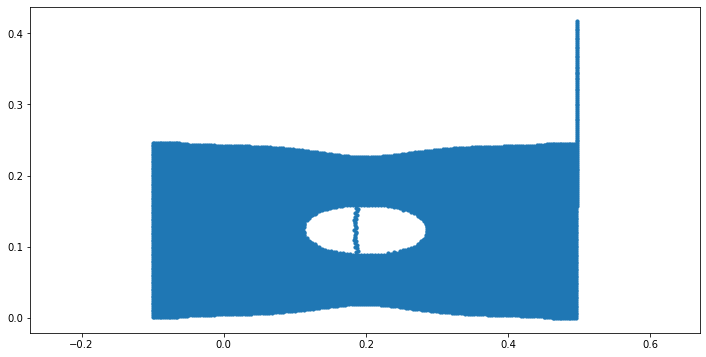

In [22]:
# %matplotlib notebook
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
dsf = 100  # displacement scale factor
ax.scatter(x[:,0] + (u[:,0] * dsf), x[:,1] + (u[:,1] * dsf), s=10)
plt.axis('equal')